In [28]:
%matplotlib inline
import math
import numpy as np
import numpy.random as nrand
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# Simulation timing

In [29]:
from stockmarket import baselinemodel

In [36]:
%prun baselinemodel.stockMarketSimulation(seed=0, simulation_time=10, amount_momentum=40, amount_mean_reversion=40, amount_firms=1,initial_money=(100, 200),initial_bid_ask=(1,1), initial_memory=(3,7),initial_ma_short=(2,3), initial_ma_long=(6,7),initial_profit=(200,200),initial_book_value=(10000, 10000),initial_stock_amount=400,order_expiration_time=120,init_propensity_to_switch=1.1,init_price_to_earnings_window=(6, 12),firm_profit_mu=0.058,firm_profit_delta=0.00396825396,firm_profit_sigma=0.125,printProgress=False)

### Savitzky_golay_filter

In [2]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

In [3]:
# simulate geometric brownian motion
def geometricBrownianPrice(previousPrice, delta, sigma, mu):
    sqrt_delta_sigma = math.sqrt(delta) * sigma
    brownian_motion = nrand.normal(loc=0, scale=sqrt_delta_sigma)
    sigma_pow_mu_delta = (mu - 0.5 * math.pow(sigma, 2.0)) * delta
    geometric_brownian_motion_log_return = brownian_motion + sigma_pow_mu_delta
    retur = np.exp(geometric_brownian_motion_log_return)
    nextPrice = previousPrice * retur
    return nextPrice

In [4]:
delta = 0.00396825396
sigma = 0.125
mu = 0.058
time = 999

In [5]:
prices = [100]
for t in range(time):
    prices.append(geometricBrownianPrice(prices[-1], delta, sigma, mu))

In [6]:
convex = [1]
for t in range(100):
    previous = convex[-1]
    convex.append(previous * 2)


In [7]:
concave = [1]
for t in range(100):
    previous = concave[-1]
    concave.append(concave[0] + previous * 0.75)
#concave

In [8]:
smoothedPrices = savitzky_golay(np.array(prices),199,1)

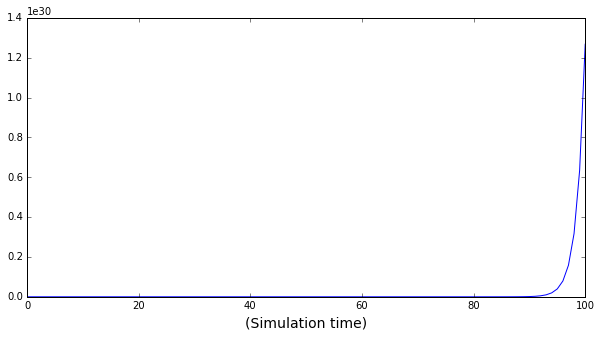

In [9]:
fig, ax1 = plt.subplots(1, 1, figsize=(10,5))

# ax1.plot(range(len(prices)), prices)
# ax1.plot(range(len(prices)), smoothedPrices)
ax1.plot(range(len(convex)), convex)

ax1.set_xlabel('(Simulation time)', fontsize='14')

# Momentum

In [16]:
shortMA = 20
longMA = 200
upperThreshold = 1.05
lowerThreshold = 0.95

In [17]:
goingUp = prices[:400]

In [18]:
short_ma = sum(goingUp[-shortMA:]) / shortMA
long_ma = sum(goingUp[-longMA:]) / longMA
short_ma / long_ma

1.0803195987941825

In [19]:
short_ma = sum(prices[-shortMA:]) / shortMA
long_ma = sum(prices[-longMA:]) / longMA
short_ma / long_ma

0.99832930053493041

In [39]:
def momentum(prices, shortMA, longMA, upper_threshold, lower_threshold):
    """Depending on stocks momentum buy, sell or hold the stock"""
    short_ma = sum(prices[(len(prices)-shortMA):]) / shortMA
    long_ma = sum(prices[(len(prices)-longMA):]) / longMA
    print('shortMA', short_ma)
    print('longMA', long_ma)
    momentum = short_ma / long_ma
    print(momentum)
    if momentum > upper_threshold:
        return 'buy'
    elif momentum < lower_threshold:
        return 'sell'
    else:
        return 'hold'

In [41]:
momentum(concave, shortMA, 200, upperThreshold, lowerThreshold) 

shortMA 3.999999999954633
longMA 1.9462500000000147
2.055234425153296


'buy'

In [45]:
momentum(goingUp, shortMA, 200, upperThreshold, lowerThreshold) 

shortMA 289.5
longMA 199.5
1.4511278195488722


'buy'

In [46]:
goingUp = [x for x in range(300)]
goingDown = [x for x in reversed(goingUp)]
goingDown

[299,
 298,
 297,
 296,
 295,
 294,
 293,
 292,
 291,
 290,
 289,
 288,
 287,
 286,
 285,
 284,
 283,
 282,
 281,
 280,
 279,
 278,
 277,
 276,
 275,
 274,
 273,
 272,
 271,
 270,
 269,
 268,
 267,
 266,
 265,
 264,
 263,
 262,
 261,
 260,
 259,
 258,
 257,
 256,
 255,
 254,
 253,
 252,
 251,
 250,
 249,
 248,
 247,
 246,
 245,
 244,
 243,
 242,
 241,
 240,
 239,
 238,
 237,
 236,
 235,
 234,
 233,
 232,
 231,
 230,
 229,
 228,
 227,
 226,
 225,
 224,
 223,
 222,
 221,
 220,
 219,
 218,
 217,
 216,
 215,
 214,
 213,
 212,
 211,
 210,
 209,
 208,
 207,
 206,
 205,
 204,
 203,
 202,
 201,
 200,
 199,
 198,
 197,
 196,
 195,
 194,
 193,
 192,
 191,
 190,
 189,
 188,
 187,
 186,
 185,
 184,
 183,
 182,
 181,
 180,
 179,
 178,
 177,
 176,
 175,
 174,
 173,
 172,
 171,
 170,
 169,
 168,
 167,
 166,
 165,
 164,
 163,
 162,
 161,
 160,
 159,
 158,
 157,
 156,
 155,
 154,
 153,
 152,
 151,
 150,
 149,
 148,
 147,
 146,
 145,
 144,
 143,
 142,
 141,
 140,
 139,
 138,
 137,
 136,
 135,
 134,
 133

# Mean reversion

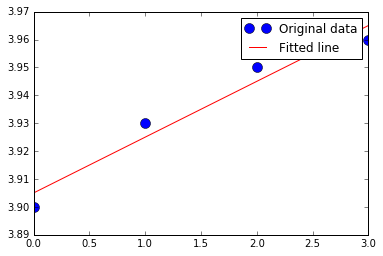

In [136]:
# identify trend in data 
x = np.array([0, 1, 2, 3])
y = np.array([3.9, 3.93, 3.95, 3.96])
A = np.vstack([x, np.ones(len(x))]).T
m, c = np.linalg.lstsq(A, y)[0]
plt.plot(x, y, 'o', label='Original data', markersize=10)
plt.plot(x, m*x + c, 'r', label='Fitted line')
plt.legend()
plt.show()

In [22]:
mean_reversion(prices, shortMA, upperThreshold, lowerThreshold)

[  99.12107406   99.26436773   99.4076614    99.55095507   99.69424874
   99.83754241   99.98083608  100.12412975  100.26742342  100.41071709
  100.55401076  100.69730443  100.8405981   100.98389178  101.12718545
  101.27047912  101.41377279  101.55706646  101.70036013  101.8436538 ]
[97.303050448053398, 97.383282536989427, 98.29102090135693, 98.917122832780365, 99.701585627634515, 100.97765247716808, 100.29290813025608, 100.70288816845013, 101.92906353416394, 102.24568836697237, 101.1725786334252, 101.15635885226227, 101.59323447309595, 103.06107763851924, 102.97530141211099, 102.10544385655608, 101.57234136002741, 99.664360862799455, 99.283311248573085, 99.319007202611843]


'hold'

In [43]:
mean_reversion(concave, shortMA=20, upper_threshold=1.0, lower_threshold=1.0)

[ 4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.  4.
  4.  4.]
[3.999999999772447, 3.999999999829335, 3.9999999998720015, 3.9999999999040012, 3.9999999999280007, 3.9999999999460005, 3.9999999999595004, 3.999999999969625, 3.999999999977219, 3.999999999982914, 3.9999999999871854, 3.999999999990389, 3.9999999999927915, 3.9999999999945937, 3.9999999999959455, 3.999999999996959, 3.999999999997719, 3.9999999999982894, 3.999999999998717, 3.9999999999990377]


'buy'

In [12]:
def mean_reversion(prices, shortMA, upper_threshold, lower_threshold):
    """Depending on the stocks trend buy or sell"""
    # identify trend based on linear regression
    prices = prices[(len(prices)-shortMA):]
    t = np.array(range(len(prices)))
    A = np.vstack([t, np.ones(len(t))]).T
    # estimate linear regression
    m, c = np.linalg.lstsq(A, prices)[0]
    trend = m*t + c
    print(trend)
    print(prices)
    if trend[-1] / prices[-1] > upper_threshold:
        return 'buy'
    elif trend[-1] / prices[-1] < lower_threshold:
        return 'sell'
    else:
        return 'hold'
     
#     stockPriceHistory = len(stock.price_history)
#     if stockPriceHistory < shortMA+1:
#         return None
#     else:
#         ma = sum(prices[-shortMA:]) / shortMA
#         growth = ma - sum(prices[-shortMA-1:-1]) / shortMA
#         predicted = ma + (shortMA/2+0.5)*growth
#         if predicted > :
#             return 'sell'
#         else:
#             return 'buy'
